# Lab 13 Presentation - Fourth Competition Round-Up

Erez Buchweitz

These data were taken from
https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview. You
may submit predictions to Kaggle and see how you would have scored on
the real competition.

# Setup simulation environment

## Load data

In [1]:
import pandas as pd

dir_path = r"../datasets/competition_4_nyc_taxi/"
X_train = pd.read_parquet(f"{dir_path}X_train.parquet")
y_train = pd.read_parquet(f"{dir_path}y_train.parquet").squeeze()
X_test = pd.read_parquet(f"{dir_path}X_test.parquet")

X_train.shape, y_train.shape, X_test.shape

((958644, 8), (958644,), (500000, 8))

## How were the data split?

In order to split `X_train` into training and validation sets, we need
to know how `X_train` was split from `X_test`. Since no one is telling,
we’ll have to find out.

**Question:** What does it matter how the data were split?

**Answer:** We want an accurate estimate of the model’s performance on
the testset. If the trainset and testset are from different months,
we’ll want to split the validset from the trainset in a similar way,
otherwise we’ll never know how the model would have performed on a
dataset from a different month. Any decision we make in the future -
about which set of hyperparameters is better, whether a given feature
improves the model, and so forth - will be biased. The same goes to any
other nonrandom split.

**Question:** How can we find out how the data were split?

In [2]:
X_train["is_test"] = 0
X_test["is_test"] = 1
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
X_all.head()

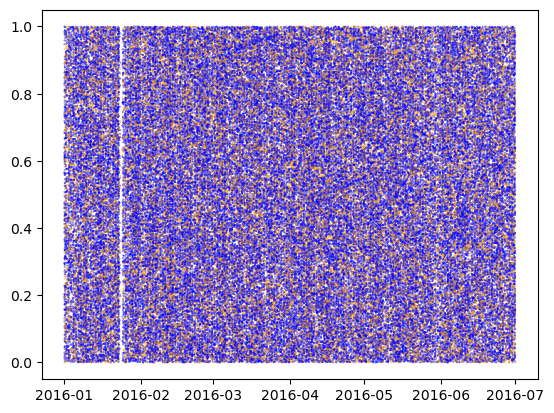

In [3]:
import matplotlib.pyplot as plt
import numpy as np

X_all["pickup_datetime"] = pd.to_datetime(X_all["pickup_datetime"])
X_all.sort_values(by="pickup_datetime", inplace=True)
X_cur = X_all.sample(frac=0.1)
plt.scatter(X_cur.pickup_datetime, np.random.rand(len(X_cur)), color=np.where(X_cur.is_test, "orange", "blue"), alpha=0.7, s=0.1)

In [4]:
pd.crosstab(X_all["is_test"], X_all.pickup_datetime.dt.month, normalize="columns")

In [5]:
pd.crosstab(X_all["is_test"], X_all.pickup_datetime.dt.hour, normalize="columns")

2 rows × 24 columns

In [6]:
pd.crosstab(X_all["is_test"], X_all.pickup_datetime.dt.minute, normalize="columns")

2 rows × 60 columns

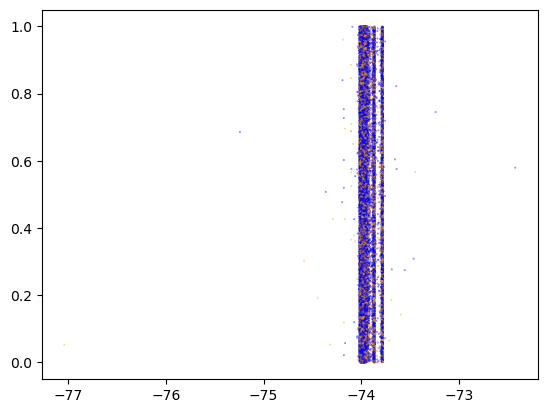

In [7]:
col = "pickup_longitude"
X_all.sort_values(by=col, inplace=True)
X_cur = X_all.sample(frac=0.1)
plt.scatter(X_cur[col], np.random.rand(len(X_cur)), color=np.where(X_cur.is_test, "orange", "blue"), alpha=0.7, s=0.1)

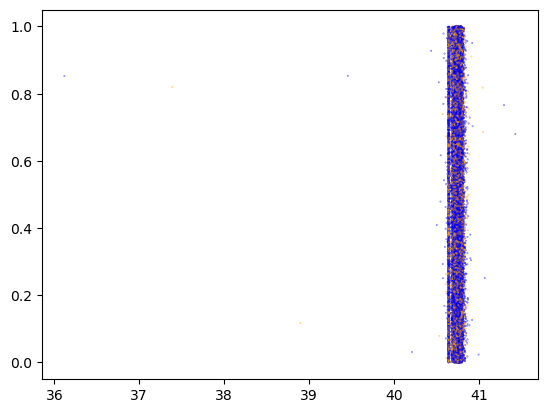

In [8]:
col = "pickup_latitude"
X_all.sort_values(by=col, inplace=True)
X_cur = X_all.sample(frac=0.1)
plt.scatter(X_cur[col], np.random.rand(len(X_cur)), color=np.where(X_cur.is_test, "orange", "blue"), alpha=0.7, s=0.1)

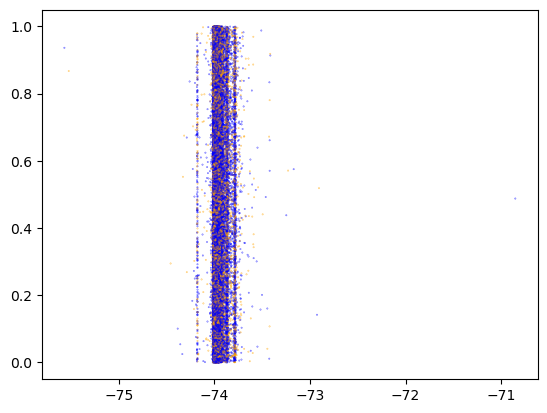

In [9]:
col = "dropoff_longitude"
X_all.sort_values(by=col, inplace=True)
X_cur = X_all.sample(frac=0.1)
plt.scatter(X_cur[col], np.random.rand(len(X_cur)), color=np.where(X_cur.is_test, "orange", "blue"), alpha=0.7, s=0.1)

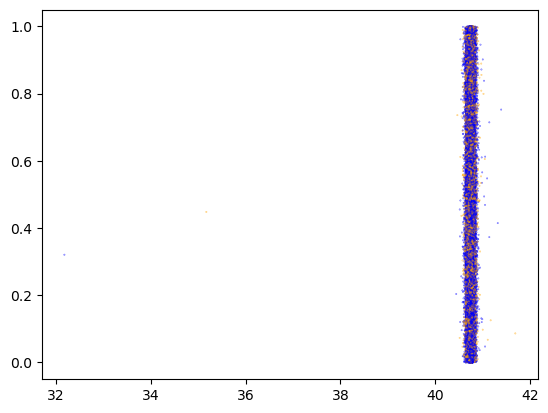

In [10]:
col = "dropoff_latitude"
X_all.sort_values(by=col, inplace=True)
X_cur = X_all.sample(frac=0.1)
plt.scatter(X_cur[col], np.random.rand(len(X_cur)), color=np.where(X_cur.is_test, "orange", "blue"), alpha=0.7, s=0.1)

In [11]:
pd.crosstab(X_all["is_test"], X_all.vendor_id)

In [12]:
pd.crosstab(X_all["is_test"], X_all.passenger_count)

In [13]:
pd.crosstab(X_all["is_test"], X_all.store_and_fwd_flag)

We have yet to find any nonrandom element in the split between `X_train`
and `X_test`.

**Question:** Are we sure the split was random?

**Answer:** No, but the odds of it being nonrandom are much smaller now,
and if it is in fact nonrandom it’s likely not egregiously so.

**Question:** Could we have automated the process we used?

**Answer:** Technically, yes, but we would have had to look at the data
manually anyway to make sure the automatic process worked correctly. If
examining randomness of split is a recurring tast, perhaps we should
consider automating it.

**Remarks:**

-   Those of you who went to the effort of thoroughly examining whether
    the split was random or not, lost valuable time. But they gained a
    valuable skill. In a real setting when you have more time, being
    thorough pay off.
-   I don’t know myself how the Kaggle competition organizers split the
    data. I couldn’t find that information on Kaggle.

## Cross validation setup

I’m not doing cross validation. As many of you saw, training a model
takes time (we’ll use GBM). Let’s consider just doing a single
train-validation split:

-   Pros: fast.
-   Cons: CV estimate of test error less accurate. (More variance, but
    still ~unbiased.)

Both choices are viable, it’s up to you to make a decision. I’ll use a
single train-validation split.

In [14]:
X_train.shape

(958644, 9)

In [15]:
if "is_test" in X_train.columns:
    X_train.drop(inplace=True, columns=["is_test"])

valid_mask = np.zeros(len(X_train), dtype=bool)
valid_mask[:200000] = True
np.random.shuffle(valid_mask)
Xa, ya = X_train.iloc[~valid_mask,:].copy(), y_train.iloc[~valid_mask]
Xb, yb = X_train.iloc[valid_mask,:].copy(), y_train.iloc[valid_mask]

Xa.shape, ya.shape, Xb.shape, yb.shape

((758644, 8), (758644,), (200000, 8), (200000,))

# Train a simple model

Let’s train a naive `lightgbm` model. (My favorite GBM library.) We’ll
use early stopping.

In [16]:
# Naively deal with non-numeric columns

Xa["store_and_fwd_flag"] = np.where(Xa["store_and_fwd_flag"] == "Y", 1, 0).astype("int8")
Xb["store_and_fwd_flag"] = np.where(Xb["store_and_fwd_flag"] == "Y", 1, 0).astype("int8")

Xa_pickup_datetime_bak = Xa["pickup_datetime"]
Xb_pickup_datetime_bak = Xb["pickup_datetime"]

Xa["pickup_datetime"] = pd.to_datetime(Xa["pickup_datetime"]).astype("int64")
Xb["pickup_datetime"] = pd.to_datetime(Xb["pickup_datetime"]).astype("int64")

In [17]:
import lightgbm as lgb

model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=0.01, 
        num_leaves=5, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.5, 
        max_depth=3,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=ya),
    valid_sets=[lgb.Dataset(Xb, label=yb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 50 rounds
[50]    valid_0's rmse: 9538.69
[100]   valid_0's rmse: 9535.05
[150]   valid_0's rmse: 9532.8
[200]   valid_0's rmse: 9531.47
[250]   valid_0's rmse: 9530.64
[300]   valid_0's rmse: 9530.08
[350]   valid_0's rmse: 9529.51
[400]   valid_0's rmse: 9529.13
[450]   valid_0's rmse: 9528.85
[500]   valid_0's rmse: 9528.65
[550]   valid_0's rmse: 9528.52
[600]   valid_0's rmse: 9528.36
[650]   valid_0's rmse: 9528.22
[700]   valid_0's rmse: 9528.05
[750]   valid_0's rmse: 9527.54
[800]   valid_0's rmse: 9527.14
[850]   valid_0's rmse: 9526.9
[900]   valid_0's rmse: 9526.74
[950]   valid_0's rmse: 9526.6
[1000]  valid_0's rmse: 9526.5
Did not meet early stopping. Best iteration is:
[1000]  valid_0's rmse: 9526.5

**Question:** What are the benefits of early stopping?

**Answer:**

-   Optimize `n_estimators` without having to retrain the model over and
    over again.
-   Regularization in choosing `n_estimators`. Consider enumerating over
    `n_estimators` in `M=[50, 100, 150, 200, ..., 950, 1000]`, computing
    loss `loss(m)` for each `m` in `M`. Two methods of choosing optimal
    value:
    -   Standard hyperparameter optimization:
        $$\hat m = \arg\min_{m \in M} loss(m).$$
    -   Early stopping:
        $$\hat m = \arg\min_{m \in M} \; loss(m) \; \text{ s.t. } \; loss(m'-1) > loss(m') \text{ for all } m'\leq m.$$

## Compute loss on validation set

Recall our loss is root mean squared logarithmic error (RMSLE): $$
    \text{RMSLE}(y, \hat y) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(y_i + 1) - \log(\hat y_i + 1))^2}.
$$

In [18]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean((np.log1p(y) - np.log1p(y_pred)) ** 2))

rmsle(yb, model.predict(Xb))

0.7308560200641739

**Question:** Is this loss unbiased?

**Answer:** No! We’ve chosen the value of `n_estimators` that’s best for
THIS PARTICULAR validset `Xc`. If we want an unbiased estimate, we’ll
have to split a third chunk `Xc` and not optimize hyperparameters on it.

**Question:** Is this a good loss?

**Answer:** Good is ALWAYS relative to the best you can achieve on this
dataset (which we don’t know), and relative to other models.

## Baseline model

Let’s see the RMSLE when we predict a constant value, the mean of `ya`.

In [19]:
rmsle(yb, ya.mean())

0.8897411363698007

So our model does better than *this* baseline.

**Question:** What is the best constant prediction for RMSLE?

**Answer:** The best constant prediction is to average after the
logarithmic transformation: $$
\log(1 + \hat y) = \frac{1}{n} \sum_{i=1}^n \log(1 + y_i).
$$ (Just call `c=log(1+yhat)` and `z_i=log(1+y_i)`, plug into the RMSLE
formula and then this result derives from what we already know about
squared error.)

In [20]:
rmsle(yb, np.expm1(np.mean(np.log1p(ya))))

0.794662568114697

Let’s see this in graphical form:

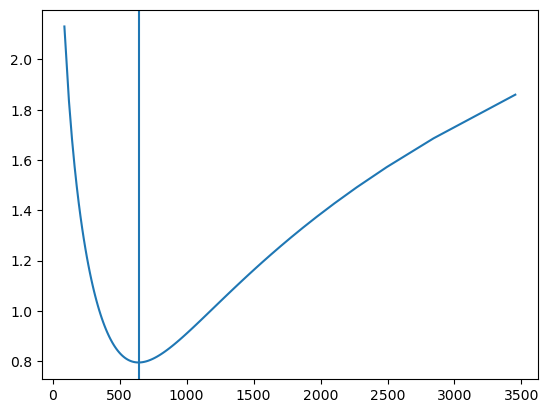

In [21]:
yy = np.quantile(yb, [i/100 for i in range(1, 100)])
plt.plot(yy, [rmsle(yb, pred) for pred in yy])
plt.axvline(np.expm1(np.mean(np.log1p(ya))))

## Optimizing RMSLE in `lightgbm`

**Question:** How do we optimize RMSLE in `lightgbm`?

**Answer:** It’s easy once we notice that RMSLE is just MSE after the
logarithmic transformation (with a square root, which changes nothing).
So just call `z_i=log(1+y_i)` and pass `z_i` to `lightgbm` as the target
variable. The predictions $\hat z_i$ will need to be translated back to
`y` via $\hat y_i = \exp(\hat z_i) - 1$.

In [22]:
za = np.log1p(ya)
zb = np.log1p(yb)

model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=0.01, 
        num_leaves=5, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.5, 
        max_depth=3,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 50 rounds
[50]    valid_0's rmse: 0.751841
[100]   valid_0's rmse: 0.728743
[150]   valid_0's rmse: 0.713245
[200]   valid_0's rmse: 0.701902
[250]   valid_0's rmse: 0.690604
[300]   valid_0's rmse: 0.679707
[350]   valid_0's rmse: 0.673911
[400]   valid_0's rmse: 0.670114
[450]   valid_0's rmse: 0.665424
[500]   valid_0's rmse: 0.661941
[550]   valid_0's rmse: 0.659572
[600]   valid_0's rmse: 0.654803
[650]   valid_0's rmse: 0.649528
[700]   valid_0's rmse: 0.644453
[750]   valid_0's rmse: 0.639967
[800]   valid_0's rmse: 0.632414
[850]   valid_0's rmse: 0.625539
[900]   valid_0's rmse: 0.62241
[950]   valid_0's rmse: 0.618983
[1000]  valid_0's rmse: 0.615224
Did not meet early stopping. Best iteration is:
[1000]  valid_0's rmse: 0.615224

In [23]:
z_pred = model.predict(Xb)
y_pred = np.expm1(z_pred)
rmsle(yb, y_pred)

0.6152242351101661

**Question:** Why did early stopping never occur? What should we do
about it?

**Answer:** It means that the model would have wanted more trees.
Alternatively, let’s increase `learning_rate` so training will be
faster.

Let’s increase `learning_rate` to tenfold, and also relax
`early_stopping_rounds` to 100. (**Question:** Why?)

In [24]:
model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=0.1, 
        num_leaves=5, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.5,
        max_depth=3,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.656534
[100]   valid_0's rmse: 0.614866
[150]   valid_0's rmse: 0.595391
[200]   valid_0's rmse: 0.584626
[250]   valid_0's rmse: 0.574631
[300]   valid_0's rmse: 0.566797
[350]   valid_0's rmse: 0.557112
[400]   valid_0's rmse: 0.54915
[450]   valid_0's rmse: 0.543712
[500]   valid_0's rmse: 0.539382
[550]   valid_0's rmse: 0.53609
[600]   valid_0's rmse: 0.533349
[650]   valid_0's rmse: 0.530487
[700]   valid_0's rmse: 0.528462
[750]   valid_0's rmse: 0.525772
[800]   valid_0's rmse: 0.524057
[850]   valid_0's rmse: 0.521343
[900]   valid_0's rmse: 0.519295
[950]   valid_0's rmse: 0.517705
[1000]  valid_0's rmse: 0.516566
Did not meet early stopping. Best iteration is:
[1000]  valid_0's rmse: 0.516566

Still no early stopping! Let’s be braver. And also try to relax other
hyperparameters.

In [25]:
model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=1, 
        num_leaves=20, 
        colsample_bytree=0.8, 
        subsample=0.5,
        max_depth=4,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.519206
[100]   valid_0's rmse: 0.502195
[150]   valid_0's rmse: 0.493461
[200]   valid_0's rmse: 0.487776
[250]   valid_0's rmse: 0.484353
[300]   valid_0's rmse: 0.481256
[350]   valid_0's rmse: 0.479324
[400]   valid_0's rmse: 0.47777
[450]   valid_0's rmse: 0.476754
[500]   valid_0's rmse: 0.475715
[550]   valid_0's rmse: 0.474699
[600]   valid_0's rmse: 0.474244
[650]   valid_0's rmse: 0.473851
[700]   valid_0's rmse: 0.473204
[750]   valid_0's rmse: 0.472304
[800]   valid_0's rmse: 0.471936
[850]   valid_0's rmse: 0.471507
[900]   valid_0's rmse: 0.471186
[950]   valid_0's rmse: 0.470625
[1000]  valid_0's rmse: 0.470339
Did not meet early stopping. Best iteration is:
[993]   valid_0's rmse: 0.470323

We see that early stopping is still not reached, but improvement
plateaus. Let’s not pursue this further for now, and move on to
something else.

Check RMSLE on validset:

In [26]:
rmsle(yb, np.expm1(model.predict(Xb)))

0.47032286878898283

It’s obviously the same, after we fed the model the transformed targets.
So we don’t need to perform this check any more.

# Feature engineering

## Naive date and time features

In [27]:
Xa_dt = pd.to_datetime(Xa_pickup_datetime_bak)
Xa["month"] = Xa_dt.dt.month
Xa["day"] = Xa_dt.dt.day
Xa["hour"] = Xa_dt.dt.hour
Xa["minute"] = Xa_dt.dt.minute
Xa["dayofweek"] = Xa_dt.dt.dayofweek

Xb_dt = pd.to_datetime(Xb_pickup_datetime_bak)
Xb["month"] = Xb_dt.dt.month
Xb["day"] = Xb_dt.dt.day
Xb["hour"] = Xb_dt.dt.hour
Xb["minute"] = Xb_dt.dt.minute
Xb["dayofweek"] = Xb_dt.dt.dayofweek

**Question:** Why would this help? Does the model not have the
information already?

**Answer:** All the information is present in the raw `pickup_datatime`.
But in order to extract the hour 10 am, for example, a decision tree
will have to make splits on `pickup_datetime` to extract 10 am for every
single day. It’s possible, but:

-   It takes a lot of splits that can be used for other meaningful
    features instead.
-   A decision tree is greedy and cannot see ahead, so it will have to
    find that a split for the hour 10 am on a particular day is
    meaningful on its own, then the next day, then the next day. And a
    single day has few data!

In [28]:
model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=1, 
        num_leaves=20, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.5,
        max_depth=4,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.490748
[100]   valid_0's rmse: 0.470895
[150]   valid_0's rmse: 0.462985
[200]   valid_0's rmse: 0.457184
[250]   valid_0's rmse: 0.453291
[300]   valid_0's rmse: 0.449182
[350]   valid_0's rmse: 0.447313
[400]   valid_0's rmse: 0.445341
[450]   valid_0's rmse: 0.444257
[500]   valid_0's rmse: 0.442205
[550]   valid_0's rmse: 0.441004
[600]   valid_0's rmse: 0.439624
[650]   valid_0's rmse: 0.438791
[700]   valid_0's rmse: 0.438309
[750]   valid_0's rmse: 0.437828
[800]   valid_0's rmse: 0.437221
[850]   valid_0's rmse: 0.436796
[900]   valid_0's rmse: 0.436491
[950]   valid_0's rmse: 0.436469
[1000]  valid_0's rmse: 0.436029
Did not meet early stopping. Best iteration is:
[999]   valid_0's rmse: 0.436011

Ok! That’s better. Lets’ move on.

## Naive location features

Let’s add a bunch of distance metrics that students used during the
competition.

In [29]:
def haversine_formula(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

def add_distance_features(X):
    X["distance_km"] = haversine_formula(X["pickup_latitude"], X["pickup_longitude"], X["dropoff_latitude"], X["dropoff_longitude"])
    X['ydistance'] = (X['dropoff_longitude'] - X['pickup_longitude'])
    X['xdistance'] = (X['dropoff_latitude'] - X['pickup_latitude'])
    X['man_dist'] = X['ydistance'].abs() + X['xdistance'].abs()
    X['r'] = np.sqrt(X['xdistance']**2 + X['ydistance']**2)
    X['theta'] = np.arctan(X['ydistance']/X['xdistance'])

add_distance_features(Xa)
add_distance_features(Xb)   

In [30]:
model = lgb.train(
    params = dict(
        n_estimators=1000, 
        learning_rate=1, 
        num_leaves=20, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.5,
        max_depth=4,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.410308
[100]   valid_0's rmse: 0.404485
[150]   valid_0's rmse: 0.402239
[200]   valid_0's rmse: 0.40144
[250]   valid_0's rmse: 0.4011
[300]   valid_0's rmse: 0.400987
[350]   valid_0's rmse: 0.401246
[400]   valid_0's rmse: 0.40124
Early stopping, best iteration is:
[318]   valid_0's rmse: 0.400638

Better!

## Hyperparameter optimization

At this point, what separates us from the number one spot is
hyperparameter optimization, in particular the revelation that really
deep trees (large `max_depth`) help. Unfortunately, training a model
takes some time, so that limits our ability to enumerate over many sets
of hyperparameters. To minimize running time to the extent that we can,
remember that we already:

-   Used a single train-validation split, instead of cross validation.
-   Used early stopping, so we get tuning of `n_estimators` for free.
-   Used `lightgbm` which is, as far as I know, the fastest GBM library.

**But notice that once more we have a computational constraint!**

We’ll add one more trick to the mix:

-   Heavy subsampling (small `subsample`). Then means that every tree
    will be fit on a small subset of the data, which means faster.

**Question:** What’s the downside of heavy subsampling?

**Answer:** There could be a price to pay in terms of RMSLE. (Is it
worth the price?)

## First round of hyperparameter optimization

Let’s enumerate what I think are the most important hyperparameters,
`learning_rate` and `max_depth`. Remember that we get `n_estimators` for
free.

In [33]:
res = []
i = 0
for learning_rate in [0.01, 0.05, 0.1, 0.5, 1]:
    for max_depth in [4, 6, 8, 10, 12]:
        i += 1
        print(f"{i=}: {learning_rate=}, {max_depth=}")
        model = lgb.train(
            params = dict(
                n_estimators=2000, 
                learning_rate=learning_rate,
                min_child_samples=50, 
                num_leaves=500, 
                colsample_bytree=0.8, 
                subsample=0.1,
                max_depth=max_depth,
                metric="rmse",
                verbosity=-1,
            ),
            train_set=lgb.Dataset(Xa, label=za),
            valid_sets=[lgb.Dataset(Xb, label=zb)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(50),
            ],
        )
        loss = rmsle(yb, np.expm1(model.predict(Xb)))
        res.append(dict(
            learning_rate=learning_rate,
            max_depth=max_depth,
            loss=loss,
        ))
res = pd.DataFrame(res)
pd.crosstab(res.learning_rate, res.max_depth, values=res.loss, aggfunc="mean").round(3)

i=1: learning_rate=0.01, max_depth=4
Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.621533
[100]   valid_0's rmse: 0.537739
[150]   valid_0's rmse: 0.498199
[200]   valid_0's rmse: 0.477213
[250]   valid_0's rmse: 0.464478
[300]   valid_0's rmse: 0.455243
[350]   valid_0's rmse: 0.448487
[400]   valid_0's rmse: 0.442765
[450]   valid_0's rmse: 0.438221
[500]   valid_0's rmse: 0.434611
[550]   valid_0's rmse: 0.431575
[600]   valid_0's rmse: 0.429046
[650]   valid_0's rmse: 0.426862
[700]   valid_0's rmse: 0.425057
[750]   valid_0's rmse: 0.423367
[800]   valid_0's rmse: 0.421849
[850]   valid_0's rmse: 0.420552
[900]   valid_0's rmse: 0.419375
[950]   valid_0's rmse: 0.418312
[1000]  valid_0's rmse: 0.417319
[1050]  valid_0's rmse: 0.416395
[1100]  valid_0's rmse: 0.415514
[1150]  valid_0's rmse: 0.414751
[1200]  valid_0's rmse: 0.414078
[1250]  valid_0's rmse: 0.413424
[1300]  valid_0's rmse: 0.412838
[1350]  valid_0's rmse: 0.412335
[1400]  va

Notice two things:

-   Deep trees improve the model. Optimal: `max_depth=12` and
    `learning_rate=0.05`.
-   This still takes a lot of time, despite our best efforts.

**Question:** What does this mean?

**Answer:** The model wants high-level interactions between features,
which cannot be captured by shallow trees. This means there is room for
more feature engineering, if we can understand what kind of interactions
the model is trying to capture.

Let’s not spend time on more hyperparameter optimization.

## More room for feature engineering

Let’s add: distance and direction to midtown Manhattan.

In [63]:
center_longitude = 40.7549
center_latitude = -73.9840
Xa["pickup_distance_from_center"] = (Xa["pickup_longitude"] - center_longitude) ** 2 + (Xa["pickup_latitude"] - center_latitude) ** 2
Xa["dropoff_distance_from_center"] = (Xa["dropoff_longitude"] - center_longitude) ** 2 + (Xa["dropoff_latitude"] - center_latitude) ** 2
Xa["pickup_direction_from_center"] = (Xa["pickup_latitude"] - center_latitude) / (Xa["pickup_longitude"] - center_longitude)
Xa["dropoff_direction_from_center"] = (Xa["dropoff_latitude"] - center_latitude) / (Xa["dropoff_longitude"] - center_longitude)
Xb["pickup_distance_from_center"] = (Xb["pickup_longitude"] - center_longitude) ** 2 + (Xb["pickup_latitude"] - center_latitude) ** 2
Xb["dropoff_distance_from_center"] = (Xb["dropoff_longitude"] - center_longitude) ** 2 + (Xb["dropoff_latitude"] - center_latitude) ** 2
Xb["pickup_direction_from_center"] = (Xb["pickup_latitude"] - center_latitude) / (Xb["pickup_longitude"] - center_longitude)
Xb["dropoff_direction_from_center"] = (Xb["dropoff_latitude"] - center_latitude) / (Xb["dropoff_longitude"] - center_longitude)

In [65]:
model = lgb.train(
    params = dict(
        n_estimators=2000, 
        learning_rate=0.05, 
        num_leaves=500, 
        min_child_sample=50,
        colsample_bytree=0.8, 
        subsample=0.1,
        max_depth=12,
        metric="rmse",
        verbosity=-1,
    ),
    train_set=lgb.Dataset(Xa, label=za),
    valid_sets=[lgb.Dataset(Xb, label=zb)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50),
    ],
)

Training until validation scores don't improve for 100 rounds
[50]    valid_0's rmse: 0.407923
[100]   valid_0's rmse: 0.390022
[150]   valid_0's rmse: 0.384308
[200]   valid_0's rmse: 0.381103
[250]   valid_0's rmse: 0.37949
[300]   valid_0's rmse: 0.378108
[350]   valid_0's rmse: 0.377266
[400]   valid_0's rmse: 0.37667
[450]   valid_0's rmse: 0.376196
[500]   valid_0's rmse: 0.375726
[550]   valid_0's rmse: 0.375311
[600]   valid_0's rmse: 0.375044
[650]   valid_0's rmse: 0.374731
[700]   valid_0's rmse: 0.374496
[750]   valid_0's rmse: 0.374414
[800]   valid_0's rmse: 0.3743
[850]   valid_0's rmse: 0.374134
[900]   valid_0's rmse: 0.373973
[950]   valid_0's rmse: 0.373865
[1000]  valid_0's rmse: 0.373777
[1050]  valid_0's rmse: 0.373726
[1100]  valid_0's rmse: 0.373658
[1150]  valid_0's rmse: 0.373574
[1200]  valid_0's rmse: 0.373557
[1250]  valid_0's rmse: 0.373524
[1300]  valid_0's rmse: 0.37349
[1350]  valid_0's rmse: 0.373453
[1400]  valid_0's rmse: 0.373428
[1450]  valid_0's r

Nice-ish. But not everything you’ll try will improve the model. Examples
of things I tried bu didn’t work:

-   Average `y` this hour. (This is called ‘target encoding’).
-   Average `y` this hour in my grid cell (after partitioning into 10x10
    grid).
-   Pretrain model only on longitudes and latitudes, use that as an
    initial state for full model.

# Explaining the model

Obviously, it’s hard to visualize a depth 12 tree.

## How many times feature was split on

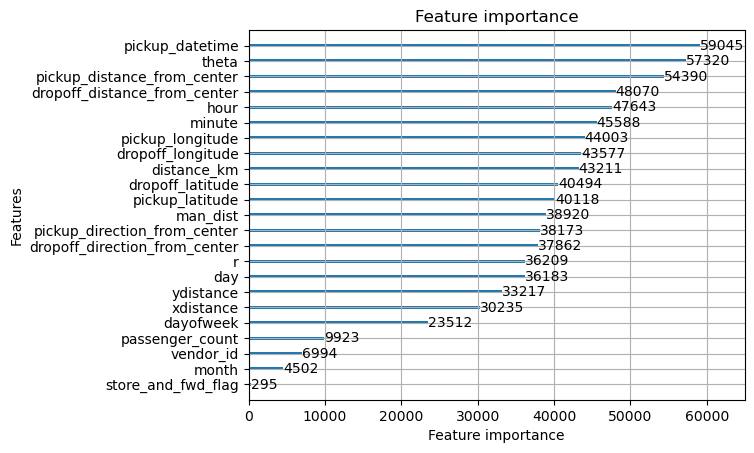

In [69]:
lgb.plot_importance(model, importance_type="split")

## Total gain from splitting on feature

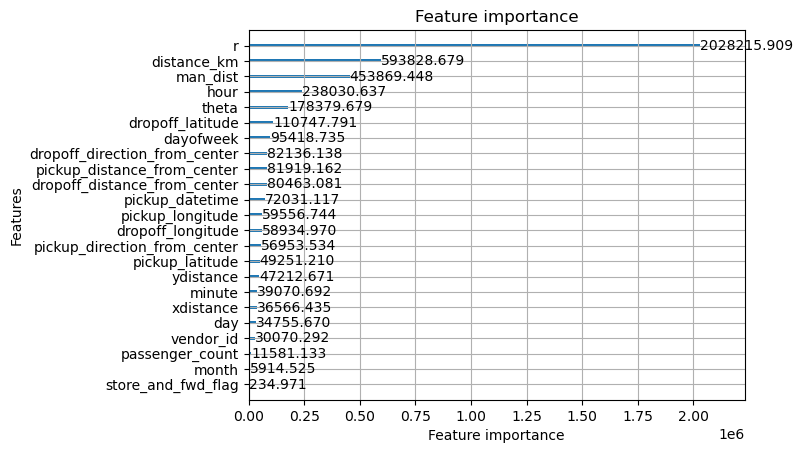

In [70]:
lgb.plot_importance(model, importance_type="gain")

In [38]:
tree = model.trees_to_dataframe()


In [39]:
tree.head()

In [40]:
tree[tree.node_depth.le(2) & tree.tree_index.le(100)].split_feature.value_counts()

split_feature
r                    75
distance_km          30
theta                30
pickup_datetime      30
dayofweek            23
hour                 22
vendor_id            18
dropoff_latitude     14
passenger_count      13
pickup_latitude       5
pickup_longitude      5
day                   4
minute                4
ydistance             4
bin_0.0_nan_1         4
z_per_bin             4
bin_0.0_nan_0         4
xdistance             3
man_dist              3
dropoff_longitude     2
bin_3.0_1.0_1         1
bin_2.0_nan_1         1
Name: count, dtype: int64